In [94]:
from data_gen import synthetic_dataset_pyro,synthetic_dataset_linear
from dowhy import CausalModel
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pyro
from original_cevae import CEVAE
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import logging
import itertools
import pyro.distributions as dist


logging.getLogger("pyro").setLevel(logging.DEBUG)
logging.getLogger("pyro").handlers[0].setLevel(logging.DEBUG)
import torch, pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, autoguide
from pyro.optim import Adam
from pyro.infer import Predictive

## PGM

Assume a simple graphical model, as the one defined by the problem. We assume the following general relationship

$$
Z\sim \mathcal{N}(0,1)\\
X\sim \mathcal{N}(az+b,\Sigma_X)\\
T|Z\sim \text{Bernoulli}(\sigma(cz))\\
Y|Z,T\sim\mathcal{N}(et+fz,\sigma_Y)
$$

we want to find all these parameters usign variational inference

In [127]:
def model(x, t, y):
    N, D = x.shape

    a = pyro.param("a", torch.zeros(D))
    b = pyro.param("b", torch.zeros(D))
    
    c = pyro.param("c", torch.tensor(0.))
    e = pyro.param("e", torch.tensor(0.))
    f = pyro.param("f", torch.tensor(0.))

    sigmax = pyro.param("sigmax", torch.ones(D))
    sigmay = pyro.param("sigmay", torch.tensor(1.))

    with pyro.plate("data", N):
        z = pyro.sample("z", dist.Normal(0., 1.))
        loc_x = a * z.unsqueeze(-1) + b
        pyro.sample("x_obs", dist.Normal(loc_x, sigmax).to_event(1), obs=x)
        t_sample = pyro.sample("t_obs", dist.Bernoulli(logits=c * z), obs=t)
        pyro.sample("y_obs", dist.Normal(e * t_sample + f * z, sigmay), obs=y)

guide = autoguide.AutoDiagonalNormal(model, init_scale=0.1)
adam = Adam({"lr": 1e-3})
svi  = SVI(model, guide, adam, loss=Trace_ELBO())


In [128]:
def fit_full(x, t, y, n_steps=3000):
    pyro.clear_param_store()
    for step in range(n_steps):
        loss = svi.step(x, t, y)
        if step % 500 == 0:
            print(f"{step:>5}  ELBO = {loss:.2f}")

In [129]:
data = synthetic_dataset_linear(n=200, beta=2.0, num_proxies=1, seed=42)

x, t, y  = (
    data["x"],
    data["t"],
    data["y"],
    )

z = data["z"]

length_x  = x.shape[1]

pyro.clear_param_store()

fit_full(x, t, y, n_steps=2000)

    0  ELBO = 1410.63
  500  ELBO = 1068.64
 1000  ELBO = 879.29
 1500  ELBO = 803.35


In [130]:
# extract trained parameters
trained_params = {}
for name, value in pyro.get_param_store().items():
    trained_params[name] = value.detach().clone()

pyro.clear_param_store()

for name, tensor in trained_params.items():
    # pyro.param registra un parametro con grad per default, ma possiamo subito settare requires_grad=False
    p = pyro.param(name, tensor)
    p.requires_grad_(False)
trained_params = {name: pyro.param(name) for name in pyro.get_param_store().keys()}
trained_params

{'a': tensor([-1.5424]),
 'b': tensor([0.1617]),
 'c': tensor(1.8327),
 'e': tensor(0.8223),
 'f': tensor(1.3104),
 'sigmax': tensor([0.7258]),
 'sigmay': tensor(0.9872),
 'AutoDiagonalNormal.loc': tensor([ 1.3479,  0.4244,  0.5160, -1.8023,  0.4246, -1.4553,  0.2296, -0.6349,
         -0.6911,  1.3706, -0.2518, -0.5798, -0.3884,  0.2320, -0.0249,  1.3872,
          1.8520, -0.4193, -0.2001,  0.5487, -0.2611,  0.4194,  0.8658,  0.7339,
          1.0477,  0.7372,  0.4911,  0.7586, -0.8025,  0.4823, -0.4464,  0.5719,
         -1.4213, -0.8937, -0.2063,  1.0553,  0.7797, -0.7738,  0.9609, -0.1407,
         -0.5368,  0.7164, -0.2974, -0.3653, -0.8047,  1.4716, -1.0282, -0.6752,
         -1.0682,  0.3221, -0.1741,  0.5451,  0.1608,  0.5906,  0.4018, -0.0197,
         -1.2230,  0.3104,  0.6915,  0.5141, -0.5435,  0.6151, -0.8100,  0.6174,
          1.1511,  0.3257,  1.5101,  0.1491, -0.1128,  0.2586, -0.2339,  1.4090,
          0.1244,  0.3610,  0.0840, -0.3862, -0.3751, -0.2742, -1.8583, -0

Interesting to observe that the coefficients are with flipped sign.
Concretely, if you replace z by −z, and simultaneously flip the signs of a, c, and f, the joint likelihood p(x, t, y | z, a, c, e, f) remains unchanged (since Normal(−a·z, σ) = Normal(a·(−z), σ), Bernoulli(logits c·z) is the same as Bernoulli(logits (−c)·(−z)), etc.). As a result, the posterior over (z, a, c, f) has two symmetric modes related by a global sign flip of z and these parameters. The inference can converge to either mode arbitrarily.

the theoretical ATE is the coefficient $e$.

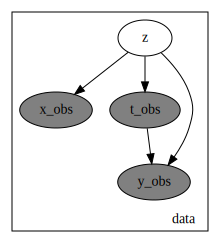

In [88]:
from pyro import render_model

import pyro.poutine as poutine

# Render the graphical model for the main model function
render_model(model, model_args=(x, t, y), render_distributions=False)

### Defining conditioned model (not useful)

In [131]:
def model_xt(x, t):
    """
    Modello generativo con parametri fissi, osserva solo x e t.
    """
    N, D = x.shape

    # Recupera parametri fissi già nel param_store
    a = pyro.param("a")      # shape [D]
    b = pyro.param("b")      # shape [D]
    c = pyro.param("c")      # scalar
    # d = pyro.param("d")      # scalar
    # parametri y li recuperiamo ma non useremo obs:
    e = pyro.param("e")
    f = pyro.param("f")
    # g = pyro.param("g")
    sigmax = pyro.param("sigmax")
    sigmay = pyro.param("sigmay")  # non usato qui come obs

    with pyro.plate("data", N):
        z = pyro.sample("z", dist.Normal(0., 1.))
        loc_x = a * z.unsqueeze(-1)
        pyro.sample("x_obs", dist.Normal(loc_x, sigmax).to_event(1), obs=x)
        logit_t = c * z
        pyro.sample("t_obs", dist.Bernoulli(logits=logit_t), obs=t)
        # Non serve includere y_obs senza obs. Se vuoi tenerla per chiarezza:
        # pyro.sample("y_latent", dist.Normal(e * t + f * z + g, sigmay))

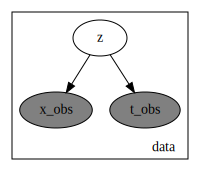

In [121]:
# reder model
render_model(model_xt, model_args=(x, t), render_distributions=False)

In [132]:
# Guida per z dato (x,t)
guide_xt = autoguide.AutoDiagonalNormal(model_xt, init_scale=0.1)

# # Ottimizzatore e SVI; notare che param_store contiene SOLO i parametri generativi congelati.
# optim_xt = Adam({"lr": 1e-2})
# svi_xt = SVI(model_xt, guide_xt, optim_xt, loss=Trace_ELBO())

# def fit_xt(x, t, n_steps=2000):
#     # Non fare clear_param_store(): altrimenti perdi i parametri fittati.
#     for step in range(n_steps):
#         loss = svi_xt.step(x, t)
#         if step % 500 == 0:
#             print(f"{step:>5}  ELBO_xt = {loss:.2f}")

# fit_xt(x, t)

In [133]:
# extract trained parameters
trained_2 = {}
for name, value in pyro.get_param_store().items():
    trained_2[name] = value.detach().clone()

pyro.clear_param_store()

for name, tensor in trained_2.items():
    # pyro.param registra un parametro con grad per default, ma possiamo subito settare requires_grad=False
    p = pyro.param(name, tensor)
    p.requires_grad_(False)
trained_2 = {name: pyro.param(name) for name in pyro.get_param_store().keys()}
trained_2

{'a': tensor([-1.5424]),
 'b': tensor([0.1617]),
 'c': tensor(1.8327),
 'e': tensor(0.8223),
 'f': tensor(1.3104),
 'sigmax': tensor([0.7258]),
 'sigmay': tensor(0.9872),
 'AutoDiagonalNormal.loc': tensor([ 1.3479,  0.4244,  0.5160, -1.8023,  0.4246, -1.4553,  0.2296, -0.6349,
         -0.6911,  1.3706, -0.2518, -0.5798, -0.3884,  0.2320, -0.0249,  1.3872,
          1.8520, -0.4193, -0.2001,  0.5487, -0.2611,  0.4194,  0.8658,  0.7339,
          1.0477,  0.7372,  0.4911,  0.7586, -0.8025,  0.4823, -0.4464,  0.5719,
         -1.4213, -0.8937, -0.2063,  1.0553,  0.7797, -0.7738,  0.9609, -0.1407,
         -0.5368,  0.7164, -0.2974, -0.3653, -0.8047,  1.4716, -1.0282, -0.6752,
         -1.0682,  0.3221, -0.1741,  0.5451,  0.1608,  0.5906,  0.4018, -0.0197,
         -1.2230,  0.3104,  0.6915,  0.5141, -0.5435,  0.6151, -0.8100,  0.6174,
          1.1511,  0.3257,  1.5101,  0.1491, -0.1128,  0.2586, -0.2339,  1.4090,
          0.1244,  0.3610,  0.0840, -0.3862, -0.3751, -0.2742, -1.8583, -0

predicting z given (x,t)

In [ ]:
predictive_xt = Predictive(model_xt, guide=guide_xt, num_samples=100, return_sites=["z"])
# Assicurati x_new: Tensor [N_new, D], t_new: Tensor [N_new] con float 0/1 o long ma cast a float.
z_t0 = predictive_xt(x, t=torch.zeros(x.shape[0]))
z_t1 = predictive_xt(x, t=torch.ones(x.shape[0]))

z_t0 = z_t0["z"]
z_t1 = z_t1["z"]

z_t0 = z_t0.mean(0)
z_t1 = z_t1.mean(0)
# Recupera i parametri generativi stimati:
e = pyro.param("e")    # scalar tensor
f = pyro.param("f")    # scalar tensor
# g = pyro.param("g")    # scalar tensor
sigmay = pyro.param("sigmay")  # scalar


loc_y_z0 = f * z_t0
loc_y_z1 = e + f * z_t1

ite = loc_y_z1 - loc_y_z0 
ite

In [171]:
ate = ite.mean().item()
print(f"ATE (ITE medio): {ate:.4f}")
print(f"ATE (true): {e}")

ATE (ITE medio): 0.8237
ATE (true): 0.8222616314888


## class compatible with run_exp()

In [91]:
def run_experiment(
    param_grid: dict,
    data_fn: callable,
    model_cls: type,
    metrics_fns: dict,
    data_kwargs: dict,
    model_kwargs: dict,
    fit_kwargs: dict,
    test_size: float = 0.2,
    random_state: int = 0,
):
    """
    Sweeps over one or more parameters (given in param_grid) and returns a DataFrame
    of results.

    param_grid: mapping from "stage__param_name" to list of values.
       e.g. {"data__shuffle_pct": np.linspace(0,1,11),
              "model__latent_dim": [1,2,5]}

    data_fn:        function(**data_kwargs) -> dict with keys "x","t","y","ite"
    
    model_cls:      class of your model; instantiated as model_cls(**model_kwargs)
    
    fit_kwargs:     kwargs passed to model.fit(...)
    
    metrics_fns:    mapping from metric_name -> function(model, x_te, ite_te) -> float

    Returns a pandas DataFrame with one row per combination, columns for each
    swept param plus each metric.
    """
    # 1) build list of all combinations
    keys, values = zip(*param_grid.items())
    combos = [dict(zip(keys, combo)) for combo in itertools.product(*values)]

    records = []
    for combo in combos:
        # prepare stage-specific kwargs
        dk = data_kwargs.copy()
        mk = model_kwargs.copy()
        fk = fit_kwargs.copy()

        # dispatch combo entries into dk/mk/fk
        for full_key, val in combo.items():
            stage, param = full_key.split("__", 1)
            if stage == "data":
                dk[param] = val
            elif stage == "model":
                mk[param] = val
            elif stage == "fit":
                fk[param] = val
            else:
                raise ValueError(f"Unknown stage “{stage}”")

        # run one trial
        data = data_fn(**dk)
        x, t, y, ite = data["x"], data["t"], data["y"], data["ite"]
        x_tr, x_te, t_tr, t_te, y_tr, y_te, ite_tr, ite_te = train_test_split(
            x, t, y, ite, test_size=test_size, random_state=random_state
        )

        pyro.clear_param_store()
        model = model_cls(**mk)
        losses = model.fit(x_tr, t_tr, y_tr, **fk)

        # 4) build result row
        row = dict(combo)
        row["final_elbo"] = losses[-1] 
        for mname, mfn in metrics_fns.items():
            row[mname] = mfn(model, x_te, ite_te)
        records.append(row)

    return pd.DataFrame.from_records(records)

# ---------------------------- metrics definition ---------------------------- #

def abs_ate_error(model, x_te, ite_te):
    est = model.ite(x_te).mean().item()
    true = ite_te.mean().item()
    return abs(est - true)

def rel_ate_error(model, x_te, ite_te):
    est = model.ite(x_te).mean().item()
    true = ite_te.mean().item()
    return abs(est - true) / abs(true)

def nrmse_ite(model, x_te, ite_te):
    pred = model.ite(x_te).cpu().numpy()
    true = ite_te.cpu().numpy()
    rmse = np.sqrt(np.mean((pred - true) ** 2))
    return rmse / true.std()


In [92]:
# 1) define your defaults
data_defaults_non_lin = dict(
    n=1000,
    num_proxies=100,
    sigma_x=1.0,
    sigma_y=1.0,
    prior_type="gaussian",
    seed=0,
)


data_defaults_linear = dict(
    n=1000,
    beta=1.0,
    num_proxies=100,
    shuffle_pct=0.0,
    sigma_x=1.0,
    sigma_y=1.0,
    seed=0,
)

data_defaults_non_lin_less_proxies = dict(
    n=2000,
    beta=2.0,
    num_proxies=10,
    prior_type="gaussian",
    sigma_x=1.0,
    sigma_y=1.0,
    seed=42,
)

model_defaults = dict(
    feature_dim=100,
    latent_dim=1,
    hidden_dim=10,
    num_layers=2,
    outcome_dist="normal",
)

fit_defaults = dict(
    num_epochs=100,
    batch_size=100,
    learning_rate=1e-2,
    weight_decay=0.0,
    log_every=0,
)

metrics = {
    "rel_ate_err": rel_ate_error,
    "nrmse_ite": nrmse_ite,
}


In [177]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, autoguide
from pyro.optim import Adam

class PyroLinearProxyModel:
    def __init__(self, init_scale=0.1, learning_rate=1e-2, weight_decay=0.0):
        """
        A simple 1-dim latent SVI model whose estimated ATE is the learned scalar 'e'.
        """
        self.init_scale     = init_scale
        self.learning_rate  = learning_rate
        self.weight_decay   = weight_decay

    def model(self, x, t, y):
        N, D = x.shape
        a      = pyro.param("a",      torch.zeros(D))
        b      = pyro.param("b",      torch.zeros(D))
        c      = pyro.param("c",      torch.tensor(0.))
        e      = pyro.param("e",      torch.tensor(0.))   # <-- ATE
        f      = pyro.param("f",      torch.tensor(0.))
        sigmax = pyro.param("sigmax", torch.ones(D))
        sigmay = pyro.param("sigmay", torch.tensor(1.))

        with pyro.plate("data", N):
            z = pyro.sample("z", dist.Normal(0., 1.))
            loc_x = a * z.unsqueeze(-1) + b
            pyro.sample("x_obs", dist.Normal(loc_x, sigmax).to_event(1), obs=x)
            pyro.sample("t_obs", dist.Bernoulli(logits=c * z),        obs=t)
            pyro.sample("y_obs", dist.Normal(e * t + f * z, sigmay),  obs=y)

    def fit(self,
            x, t, y,
            num_epochs: int = 100,
            batch_size: int = 100,       # ignored here, we do full-batch
            learning_rate: float = None,
            weight_decay: float    = None,
            log_every: int        = 0
           ):
        """
        Runs SVI on (x, t, y), returns a list of ELBO losses.
        """
        # override defaults if provided
        lr = learning_rate or self.learning_rate
        wd = weight_decay  or self.weight_decay

        pyro.clear_param_store()
        guide = autoguide.AutoDiagonalNormal(self.model, init_scale=self.init_scale)
        optim = Adam({"lr": lr, "weight_decay": wd})
        svi   = SVI(self.model, guide, optim, loss=Trace_ELBO())

        losses = []
        for epoch in range(1, num_epochs+1):
            loss = svi.step(x, t, y)
            losses.append(loss)
            if log_every and epoch % log_every == 0:
                print(f"[SVI] epoch {epoch:>4} ELBO = {loss:.2f}")

        # snapshot & freeze
        raw = {name: val.detach().clone()
               for name, val in pyro.get_param_store().items()}
        pyro.clear_param_store()
        for name, val in raw.items():
            p = pyro.param(name, val)
            p.requires_grad_(False)

        return losses

    def ite(self, x):
        """
        Returns per-unit ITE estimates.  In this linear model
        the treatment effect is constant = e.
        """
        N = x.shape[0]
        e = pyro.param("e")
        return e * torch.ones(N, dtype=x.dtype, device=x.device)

    def estimate_ate(self, x=None, t=None, y=None):
        """
        The ATE is exactly the learned 'e' scalar.
        """
        return pyro.param("e").item()


In [188]:
# model_defaults = dict(
#     feature_dim=100,
#     latent_dim=1,
#     hidden_dim=10,
#     num_layers=2,
#     outcome_dist="normal",
# )

# fit_defaults = dict(
#     num_epochs=100,
#     batch_size=100,
#     learning_rate=1e-2,
#     weight_decay=0.0,
#     log_every=0,
# )

param_grid = {
    "data__n": np.linspace(10,100, 10, dtype=int),
}

results = run_experiment(
    param_grid,
    data_fn=synthetic_dataset_pyro,
    model_cls=PyroLinearProxyModel,
    metrics_fns=metrics,
    data_kwargs=data_defaults_linear,
    model_kwargs={},
    fit_kwargs={},
)

print(results)


   data__n    final_elbo  rel_ate_err  nrmse_ite
0       10   1022.356133     1.762356   1.664470
1       20   2215.163762     0.372684   1.264364
2       30   3393.827313     0.424895   2.040260
3       40   4527.304177     0.324183   1.673492
4       50   5651.130974     0.334843   1.525788
5       60   6879.037827     0.323323   1.550403
6       70   8062.408298     0.338328   1.197921
7       80   9306.876348     0.356749   1.219711
8       90  10536.993942     0.334047   1.238904
9      100  11598.097576     0.211219   1.115439


In [181]:
def plot_experiment_results(results, x_param="data__shuffle_pct"):
    """
    Given a DataFrame `results` where one column is your swept parameter
    (e.g. "data__shuffle_pct") and the others are metrics, this function
    will produce one plot per metric.
    """
    # find all metric columns
    metrics = [c for c in results.columns if c != x_param]

    for metric in metrics:
        plt.figure(figsize=(6, 4))
        plt.plot(results[x_param], results[metric], marker="o")
        plt.xlabel(x_param)
        plt.ylabel(metric)
        plt.title(f"{metric.replace('_',' ').title()} vs {x_param}")
        plt.tight_layout()
        plt.show()

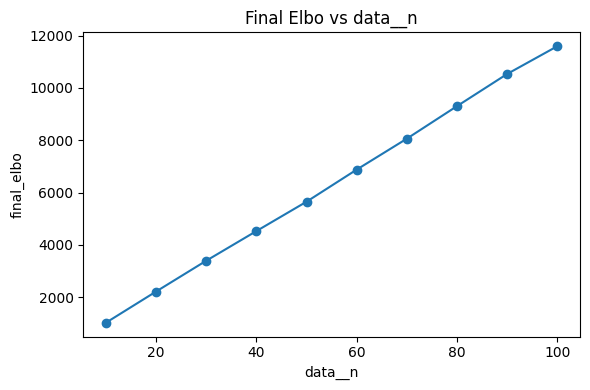

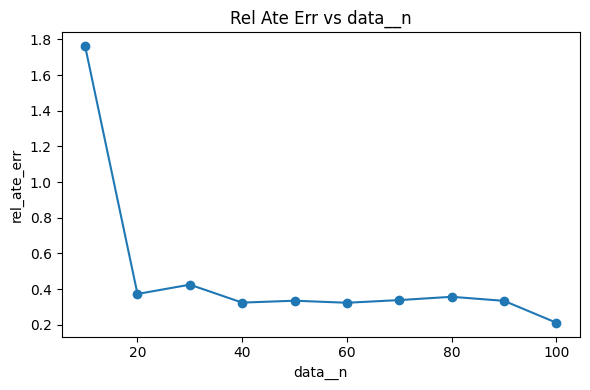

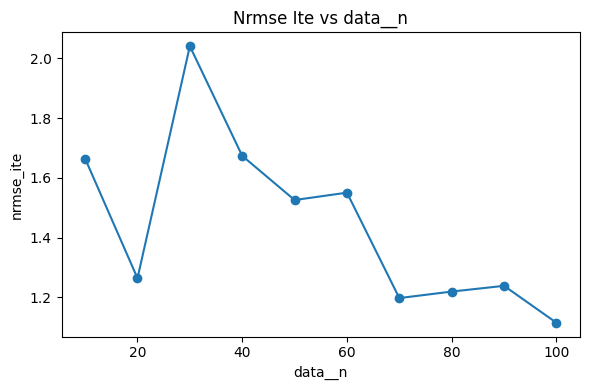

In [190]:
plot_experiment_results(results, x_param="data__n")